In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import json

import sys
sys.path.append("../../../")

from src.dataset_manager import DatasetConvertor 

========= Data Unit Summary =========
  Name:                combined_flows_forward
  Length Window:        20
  Sampling Interval Ts: 0.01
  Data Length:          104067
  Context Dimension:    12
  Compression Rate:     0.2324


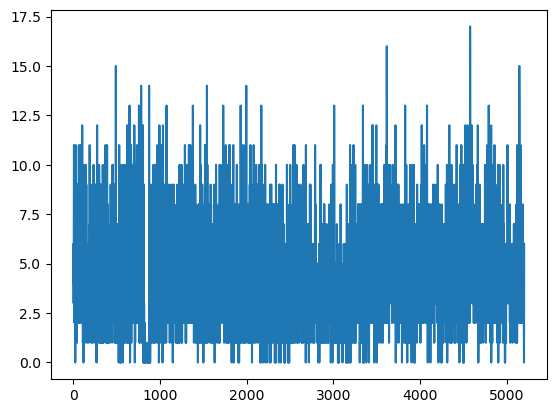

In [4]:
rawDatasetFolder = "../../../data/raw"
dpdrDatasetFolder = "../../../data/processed/dpdr"
configPaths = [
    "../../config/combined_flows_forward.json", 
    "../../config/combined_flows_backward.json"
]

datasetConverter = DatasetConvertor(rawDatasetFolder)
for configPath in configPaths:
    with open(configPath, "r") as f:
        config = json.load(f)
    datasetConverter.addDataUnit(config)
    name = config.get("NAME")
    dataUnit = datasetConverter.getDataUnit(name)
    dataUnit.saveDataUnit(f"{dpdrDatasetFolder}/{name}.csv")

dataUnit = datasetConverter.getDataUnit("combined_flows_forward")
dataUnit.display()
trffic = dataUnit.generateTrafficPattern()
plt.plot(trffic.flatten())
plt.show()

In [ ]:
from src.context_aware.preprocessing import PreprocessingDataset
from src.context_aware.config.configs import MetaConfig, ModelConfig
from src.context_aware.models import createModel

configPath = "../config/combined_flows_forward.json"
with open(configPath, "r") as f:
    config_json = json.load(f)
name = config_json.get("NAME")
len_window = config_json.get("LEN_WINDOW")
dim_data = config_json.get("DIM_DATA")
train_ratio = config_json.get("TRAIN_RATIO")


max_vals, min_vals = dataUnit.getMaxMinMbnVals()
metaConfig = MetaConfig.initialize(
    dim_data=dim_data, 
    window_length=len_window, 
    max_vals=max_vals, 
    min_vals=min_vals,
    smooth_fc=1.5,
)
dataProcessor = PreprocessingDataset(metaConfig)
dataset = dataProcessor.process(dataUnit, dataAugment=False, filterMode='filtfilt')
sources,targets,lastTranmittedContext,_,_,_,_,sourcesNoSmooth = dataset

# =============== Training ===============
modelConfig = ModelConfig.from_meta_config(metaConfig)
model, device = createModel(modelConfig)

avg_loss = 0
N_iter = 500 
for i in range(N_iter):
    idx = np.random.randint(0, len(sources))
    #sources_ = poly_fit_each_dim(sources[idx], degree=3)
    traffic_pred, motion_pred = model.inference(
        sources[idx], lastTranmittedContext[idx], sourcesNoSmooth[idx])
    avg_loss += np.mean((targets[idx][:,0].flatten() - motion_pred[:,:,0].flatten())**2)
avg_loss /= N_iter
print(f"Average loss: {avg_loss}")


Average loss: 0.000191671163913431


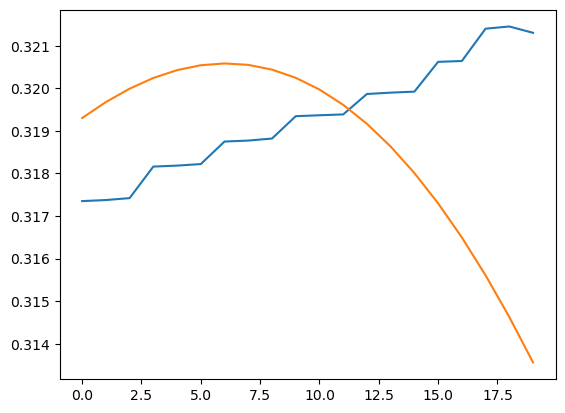

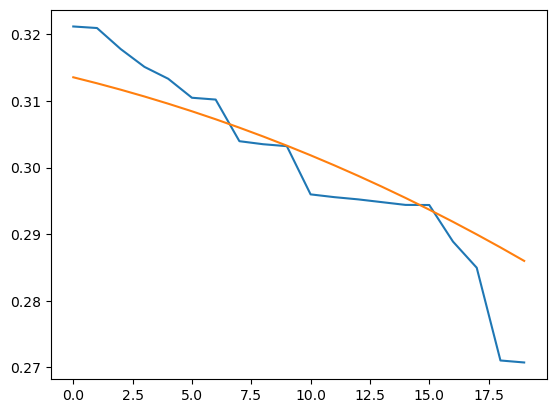

In [ ]:
idx = np.random.randint(0, len(sources))
traffic_pred, motion_pred = model.inference(sources[idx], lastTranmittedContext[idx], sourcesNoSmooth[idx])
plt.plot(sourcesNoSmooth[idx][:,0].flatten())
plt.plot(sources[idx][:,0].flatten())
plt.show()
plt.plot(targets[idx][:,0].flatten())
plt.plot(motion_pred[:,:,0].flatten())
plt.show()  